Test iminuit

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import MulensModel as mm
import scipy.optimize as op
import os
import astropy.units as u
from lmfit import create_params, minimize
from lmfit.printfuncs import report_fit
from iminuit import Minuit
from iminuit import minimize as iminuit_minimize
from scipy.optimize import OptimizeResult

gamma = 1.25

def magtoflux(mag, zeropint = 27.615):
    return 10.**(-0.4*(mag - zeropint))

def chi2_for_model(theta, event, parameters_to_fit, data_ref):
    """
    for given event set attributes from parameters_to_fit
    (list of str) to values from the theta list
    """
    for (index, key) in enumerate(parameters_to_fit):
        if (key == 't_E' or key =='rho') and theta[index] < 0.:
            return np.inf
        if key == 't_0':
            t_0 = theta[index]
        if key == 't_E':
            t_E = theta[index]
        setattr(event.model.parameters, key, theta[index])
    if len(theta) == 7:
        event.model.set_magnification_methods([t_0 - gamma*t_E, 'VBBL', t_0 + gamma*t_E])
    elif len(theta) < 7:
        event.model.set_magnification_methods([t_0 - gamma*t_E, 'finite_source_uniform_Gould94', t_0 + gamma*t_E])
    return event.get_chi2_for_dataset(data_ref)

def fit_model(event, parameters_to_fit, bounds = None, data_ref = 0):
    """
    Fit an "event" with "parameters_to_fit" as free parameters.
    
    event = a MulensModel event
    parameters_to_fit = list of parameters to fit
    """
    # Take the initial starting point from the event.
    x0 = []
    for key in parameters_to_fit:
        value = getattr(event.model.parameters, key)
        if isinstance(value, u.Quantity):
            x0.append(value.value)
        else:
            x0.append(value)
    
    def wrapped(func, args):
        return lambda x: func(x, *args)
    
    chisq_wrapped = wrapped(chi2_for_model, (event, parameters_to_fit, data_ref))
    chisq_wrapped.errordef = 1.0
    m = Minuit(chisq_wrapped, x0)
    m.limits = bounds
    m.tol = 0.0001 #0.01
    m.strategy = 1
    m.simplex(ncall=5000)
    m.strategy = 1
    m.tol = 0.0001 #0.00001
    m.migrad(ncall = 5000)
    
    
    if m.valid:
        message = "Optimization terminated successfully"
        if m.accurate:
            message += "."
        else:
            message += ", but uncertainties are unrealiable."
    else:
        message = "Optimization failed."
        fmin = m.fmin
        if fmin.has_reached_call_limit:
            message += " Call limit was reached."
        if fmin.is_above_max_edm:
            message += " Estimated distance to minimum too large."

    n = len(x0)
    result = OptimizeResult(
        x=np.array(m.values),
        success=m.valid,
        fun=m.fval,
        hess_inv=m.covariance if m.covariance is not None else np.ones((n, n)),
        message=message,
        nfev=m.nfcn,
        njev=m.ngrad,
        minuit=m,
    )

    """
    
    
    
    # *Execute fit using a 'Nelder-Mead' algorithm*
    result = op.minimize(
       chi2_for_model, x0, args=(event, parameters_to_fit, data_ref), bounds=bounds,
       method='Nelder-Mead', options={'xatol': 1e-14, 'fatol': 1e-14, 'adaptive': False, 'maxfev' : 5000})
    #result = iminuit_minimize(
       #chi2_for_model, x0, args=(event, parameters_to_fit, data_ref), bounds=bounds,
       #method='simplex', options={'disp': False, 'stra': 1, 'maxfun': 5000}, tol=0.001)
    #result = op.minimize(chi2_for_model, x0, args=(event, parameters_to_fit, data_ref), method= 'L-BFGS-B' , options={'ftol': 1e-14, 'gtol': 1e-14, 'maxfun': 2000}, bounds=bounds)
   """
    return result


def find_residuals(params, event, parameters_to_fit):
    for (index, key) in enumerate(parameters_to_fit):
        setattr(event.model.parameters, key, params[key].value)
    event.fit_fluxes()
    srcflux, bldflux = event.get_ref_fluxes()
    modelmag = event.model.get_lc(event.datasets[0].time, source_flux=srcflux, blend_flux=bldflux)
    modelflux = mm.Utils.get_flux_from_mag(modelmag)
    residuals = (event.datasets[0].flux - modelflux) / event.datasets[0].err_flux
    return residuals  

def fit_model_lm(event, parameters_to_fit, bounds = None):
    """
    Fit an "event" with "parameters_to_fit" as free parameters.
    
    event = a MulensModel event
    parameters_to_fit = list of parameters to fit
    """
    # Take the initial starting point from the event.
    x0 = []
    for key in parameters_to_fit:
        value = getattr(event.model.parameters, key)
        if isinstance(value, u.Quantity):
            x0.append(value.value)
        else:
            x0.append(value)
   
    fit_params = create_params(t_0 = dict(value=x0[0], max=bounds[0][1], min=bounds[0][0]),
                               u_0 = dict(value=x0[1], max=bounds[1][1], min=bounds[1][0]),
                               t_E = dict(value=x0[2], max=bounds[2][1], min=bounds[2][0]),
                               rho = dict(value=x0[3], max=bounds[3][1], min=bounds[3][0]),
                               s = dict(value=x0[4], max=bounds[4][1], min=bounds[4][0]),
                               q = dict(value=x0[5], max=bounds[5][1], min=bounds[5][0]),
                               alpha = dict(value=x0[6], max=bounds[6][1], min=bounds[6][0]))
    result = minimize(find_residuals, fit_params, args=(event, parameters_to_fit), max_nfev = 7500, ftol = 1e-20, gtol = 1e-20)
    return result
    
    


In [30]:
falpha = 0.0
alpha = 360.0
fu0 = -0.075
file_name = "../Multiple_lc_run1/s20p2s31p0psi60.0alpha%.1f/u%.3falpha%d"%(falpha,fu0,alpha)

#Read CB data
hjd, cbflux, cbflux_err = np.loadtxt(file_name+"_flux.txt", usecols=[0,1,2], unpack=True)
my_data = mm.MulensData([hjd, cbflux, cbflux_err], phot_fmt="flux", chi2_fmt="flux")
print("{:} file was imported".format(file_name))
true_params = np.loadtxt(file_name+"_info.txt", skiprows=1)
params_cb = {"t_0": true_params[0], "u_0": true_params[1], "t_E": true_params[2], "s2": true_params[3], "q2": true_params[4], "alpha": true_params[5], "rho": true_params[6], "s3": true_params[7], "q3": true_params[8], "psi": true_params[9]}

#Read binary data
hjd, binaryflux, binaryflux_err = np.loadtxt(file_name+"_binflux.txt", usecols=[0,1,2], unpack=True)
my_data_bin = mm.MulensData([hjd, binaryflux, binaryflux_err], phot_fmt="flux", chi2_fmt="flux")
true_params = np.loadtxt(file_name+"_bininfo.txt", skiprows=1)
params_bin = {"t_0": true_params[0], "u_0": true_params[1], "t_E": true_params[2], "s": true_params[3], "q": true_params[4], "alpha": true_params[5], "rho": true_params[6]}

#Read planet data
hjd, planetflux, planetflux_err = np.loadtxt(file_name+"_planetflux.txt", usecols=[0,1,2], unpack=True)
my_data_planet = mm.MulensData([hjd, planetflux, planetflux_err], phot_fmt="flux", chi2_fmt="flux")
true_params = np.loadtxt(file_name+"_planetinfo.txt", skiprows=1)
params_planet = {"t_0": true_params[0], "u_0": true_params[1], "t_E": true_params[2], "s": true_params[3], "q": true_params[4], "alpha": true_params[5], "rho": true_params[6]}


params_pspl = {"t_0": true_params[0], "u_0": true_params[1], "t_E": true_params[2], "rho": true_params[6]}

true_chisq = len(cbflux) - len(params_bin)



../Multiple_lc_run1/s20p2s31p0psi60.0alpha0.0/u-0.075alpha360 file was imported


In [31]:
import scipy.optimize as op
from scipy.optimize import Bounds

t_0 = params_bin['t_0']
u_0 = params_bin['u_0']
t_E = params_bin['t_E']
rho = params_bin['rho']
sbin = params_bin['s']
qbin = params_bin['q']
alphabin = params_bin['alpha']
splanet = params_planet['s']
qplanet = params_planet['q']
alphaplanet = params_planet['alpha']
u0planet = params_planet['u_0']
gamma = 1.25

pspl_model = mm.Model({'t_0': t_0, 'u_0': u_0, 't_E': t_E, 'rho': rho})
pspl_model.set_magnification_methods([t_0 - gamma*t_E, 'finite_source_uniform_Gould94', t_0 + gamma*t_E])
planet_model = mm.Model({'t_0': t_0, 'u_0': u0planet, 't_E': t_E, 's': splanet, 'q': qplanet, 'alpha': alphaplanet, 'rho': rho})
planet_model.set_magnification_methods([t_0 - gamma*t_E, 'VBBL', t_0 + gamma*t_E])
binary_model = mm.Model({'t_0': t_0, 'u_0': u_0, 't_E': t_E, 's': sbin, 'q': qbin, 'alpha': alphabin, 'rho': rho})
binary_model.set_magnification_methods([t_0 - gamma*t_E, 'VBBL', t_0 + gamma*t_E])

my_event = mm.Event(datasets=[my_data], model=pspl_model)
init_fit = mm.FitData(dataset=my_data, model=pspl_model)
init_fit.fit_fluxes()
sourceflux = init_fit.source_flux
blendflux = init_fit.blend_flux
psplmaginit = pspl_model.get_lc(my_data.time, source_flux=sourceflux, blend_flux=blendflux)
psplfluxinit = mm.Utils.get_flux_from_mag(psplmaginit)
deltax2init = my_event.get_chi2_for_dataset(0) - true_chisq
print("delta chi-square = ", deltax2init)



parameters_to_fit = ["t_0", "u_0", "t_E", "rho"]
bounds = ((0.,10000), (-10.0, 10.0), (0., 100.), (0.0, 1.0)) 
result = fit_model(my_event, parameters_to_fit, bounds)
print("Fitting was successful? {:}".format(result.success))
if not result.success:
    print(result.message)
print("Function evaluations: {:}".format(result.nfev))
if isinstance(result.fun, np.ndarray):
    if result.fun.ndim == 0:
        result_fun = float(result.fun)
    else:
        result_fun = result.fun[0]
else:
    result_fun = result.fun
print("The smallest function value: {:.3f}".format(result_fun))
print("for parameters: {:.5f} {:.4f} {:.3f} {:.3f}".format(*result.x.tolist()))
sourceflux = my_event.get_flux_for_dataset(0)[0]
blendflux = my_event.get_flux_for_dataset(0)[1]
print("Magnitude: %.5f %.5f"%(mm.Utils.get_mag_from_flux(sourceflux),mm.Utils.get_mag_from_flux(blendflux)))
deltax2fin = my_event.get_chi2_for_dataset(0) - true_chisq
print("delta chi-square = ", deltax2fin)

sourceflux, blendflux = my_event.get_ref_fluxes()
psplmagfin = my_event.model.get_lc(my_data.time, source_flux=sourceflux, blend_flux=blendflux)
psplfluxfin = mm.Utils.get_flux_from_mag(psplmagfin)

params_psplfinal = {"t_0": result.x[0], "u_0": result.x[1], "t_E": result.x[2], "rho": result.x[3]}



delta chi-square =  322752.8416682055
Fitting was successful? False
Optimization failed. Estimated distance to minimum too large.
Function evaluations: 623
The smallest function value: 326212.495
for parameters: 2000.14496 -0.0644 35.678 0.000
Magnitude: 14.60370 16.93776
delta chi-square =  319019.4949908999


/var/folders/hn/6p7kgmw55kn4chlmx3c4v4pw0000gp/T/ipykernel_89764/3066610134.py:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Magnitude: %.5f %.5f"%(mm.Utils.get_mag_from_flux(sourceflux),mm.Utils.get_mag_from_flux(blendflux)))


In [4]:
#Fit a binary model
my_event.model = binary_model
init_fit = mm.FitData(dataset=my_data, model=binary_model)
init_fit.fit_fluxes()
sourceflux = init_fit.source_flux
blendflux = init_fit.blend_flux
binmaginit = binary_model.get_lc(my_data.time, source_flux=sourceflux, blend_flux=blendflux)
binfluxinit = mm.Utils.get_flux_from_mag(binmaginit)
print("delta chi-square = ", my_event.get_chi2_for_dataset(0)- true_chisq)

parameters_to_fit = ["t_0", "u_0", "t_E", "rho", "s", "q", "alpha"]
bounds = ((t_0 - 100, t_0 + 100), (-10.0, 10.0), (10., 50.), (0.0, 1.0), (0.0, 10.0),(0.0, 1.0), (0., 360.)) 
result = fit_model(my_event, parameters_to_fit, bounds)
print("Fitting was successful? {:}".format(result.success))
if not result.success:
    print(result.message)
print("Function evaluations: {:}".format(result.nfev))
if isinstance(result.fun, np.ndarray):
    if result.fun.ndim == 0:
        result_fun = float(result.fun)
    else:
        result_fun = result.fun[0]
else:
    result_fun = result.fun
print("The smallest function value: {:.3f}".format(result_fun))
print("for parameters: {:.5f} {:.4f} {:.3f} {:.3f} {:.3f} {:.4f} {:.2f}".format(*result.x.tolist()))
sourceflux = my_event.get_flux_for_dataset(0)[0]
blendflux = my_event.get_flux_for_dataset(0)[1]
print("Magnitude: %.5f %.5f"%(mm.Utils.get_mag_from_flux(sourceflux),mm.Utils.get_mag_from_flux(blendflux)))
print("delta chi-square = ", my_event.get_chi2_for_dataset(0)- true_chisq)

sourceflux, blendflux = my_event.get_ref_fluxes()
binmagfin = my_event.model.get_lc(my_data.time, source_flux=sourceflux, blend_flux=blendflux)
binfluxfin = mm.Utils.get_flux_from_mag(binmagfin)
params_binfinal = {"t_0": result.x[0], "u_0": result.x[1], "t_E": result.x[2], "rho": result.x[3], "s": result.x[4], "q": result.x[5], "alpha": result.x[6]}


delta chi-square =  323106.04977431684


: 

: 

In [10]:
#Fit a planet model
my_event.model = planet_model
init_fit = mm.FitData(dataset=my_data, model=planet_model)
init_fit.fit_fluxes()
sourceflux = init_fit.source_flux
blendflux = init_fit.blend_flux
planetmaginit = planet_model.get_lc(my_data.time, source_flux=sourceflux, blend_flux=blendflux)
planetfluxinit = mm.Utils.get_flux_from_mag(planetmaginit)
print("delta chi-square = ", my_event.get_chi2_for_dataset(0)- true_chisq)

parameters_to_fit = ["t_0", "u_0", "t_E", "rho", "s", "q", "alpha"]
bounds = ((t_0 - 100, t_0 + 100), (-10.0, 10.0), (10., 100.), (0.0, 1.0), (0.001, 10.0),(0.0, 1.0), (0., 360.)) 
result = fit_model(my_event, parameters_to_fit, bounds)
print("Fitting was successful? {:}".format(result.success))
if not result.success:
    print(result.message)
print("Function evaluations: {:}".format(result.nfev))
if isinstance(result.fun, np.ndarray):
    if result.fun.ndim == 0:
        result_fun = float(result.fun)
    else:
        result_fun = result.fun[0]
else:
    result_fun = result.fun
print("The smallest function value: {:.3f}".format(result_fun))
print("for parameters: {:.5f} {:.4f} {:.3f} {:.3f} {:.3f} {:.4f} {:.2f}".format(*result.x.tolist()))
sourceflux = my_event.get_flux_for_dataset(0)[0]
blendflux = my_event.get_flux_for_dataset(0)[1]
print("Magnitude: %.5f %.5f"%(mm.Utils.get_mag_from_flux(sourceflux),mm.Utils.get_mag_from_flux(blendflux)))
print("delta chi-square = ", my_event.get_chi2_for_dataset(0)- true_chisq)

sourceflux, blendflux = my_event.get_ref_fluxes()
planetmagfin = my_event.model.get_lc(my_data.time, source_flux=sourceflux, blend_flux=blendflux)
planetfluxfin = mm.Utils.get_flux_from_mag(planetmagfin)
params_planetfinal = {"t_0": result.x[0], "u_0": result.x[1], "t_E": result.x[2], "rho": result.x[3], "s": result.x[4], "q": result.x[5], "alpha": result.x[6]}



delta chi-square =  13372.995544714751


KeyboardInterrupt: 

In [11]:
sgns = np.random.choice([-1,1], size = 7)
planet2_model = mm.Model({'t_0': t_0 + sgns[0]*0.10, 'u_0': u0planet + sgns[1]*0.010*u0planet, 't_E': t_E + sgns[2]*0.010*t_E, 's': splanet + sgns[3]*0.010*splanet, 'q': qplanet + sgns[4]*0.010*qplanet, 'alpha': alphaplanet + sgns[5]*0.25, 'rho': rho + sgns[6]*0.010*rho})
planet2_model.set_magnification_methods([t_0 - 0.5*t_E, 'VBBL', t_0 + 0.5*t_E])
params_planetinit = {'t_0': t_0 + sgns[0]*0.10, 'u_0': u0planet + sgns[1]*0.010*u0planet, 't_E': t_E + sgns[2]*0.010*t_E, 's': splanet + sgns[3]*0.010*splanet, 'q': qplanet + sgns[4]*0.010*qplanet, 'alpha': alphaplanet + sgns[5]*0.25, 'rho': rho + sgns[6]*0.010*rho}
my_event_planet = mm.Event(datasets=[my_data_planet], model=planet2_model)
init_fit = mm.FitData(dataset=my_data_planet, model=planet2_model)
init_fit.fit_fluxes()
initsourceflux = init_fit.source_flux
initblendflux = init_fit.blend_flux
deltax2init = my_event_planet.get_chi2_for_dataset(0)- true_chisq
print("Initial delta chi-square planet-planet = ", deltax2init)
parameters_to_fit = ["t_0", "u_0", "t_E", "rho", "s", "q", "alpha"]
bounds = ((t_0 - 100, t_0 + 100), (-10.0, 10.0), (1., 100.), (0.0, 1.0), (0.0, 100.0),(0.0, 1.0), (0.0, 360.)) 
result = fit_model(my_event_planet, parameters_to_fit, bounds)
print("Fitting was successful? {:}".format(result.success))
if not result.success:
    print(result.message)
print("Function evaluations: {:}".format(result.nfev))
if isinstance(result.fun, np.ndarray):
    if result.fun.ndim == 0:
        result_fun = float(result.fun)
    else:
        result_fun = result.fun[0]
else:
    result_fun = result.fun
print("The smallest function value: {:.3f}".format(result_fun))#result.chisqr
print("for parameters: , {:.5f} {:.4f} {:.3f} {:.3f} {:.3f} {:.4f} {:.2f}".format(*result.x.tolist()))#result.params)#
finsourceflux = my_event_planet.get_flux_for_dataset(0)[0]
finblendflux = my_event_planet.get_flux_for_dataset(0)[1]
deltax2fin = my_event_planet.get_chi2_for_dataset(0)- true_chisq
print("Final delta chi-square planet-planet = ", deltax2fin)
params_planet2final = {"t_0": result.x[0], "u_0": result.x[1], "t_E": result.x[2], "rho": result.x[3], "s": result.x[4], "q": result.x[5], "alpha": result.x[6]} 

Initial delta chi-square planet-planet =  187708.9238771471
Fitting was successful? False
Maximum number of function evaluations has been exceeded.
Function evaluations: 5000
The smallest function value: 14131.733
for parameters: , 2000.00024 -0.0716 31.208 0.001 0.951 0.0005 295.49
Final delta chi-square planet-planet =  6938.732994390361


In [61]:

sgns = np.random.choice([-1,1], size = 7)
binary2_model = mm.Model({'t_0': t_0 + sgns[0]*0.25, 'u_0': u_0 + sgns[1]*0.025*u_0, 't_E': t_E + sgns[2]*0.025*t_E, 's': sbin + sgns[3]*0.025*sbin, 'q': qbin + sgns[4]*0.025*qbin, 'alpha': alphabin + sgns[5]*0.5, 'rho': rho + sgns[6]*0.025*rho})
binary2_model.set_magnification_methods([t_0 - gamma*t_E, 'VBBL', t_0 + gamma*t_E])
params_bininit = {'t_0': t_0 + sgns[0]*0.25, 'u_0': u_0 + sgns[1]*0.025*u_0, 't_E': t_E + sgns[2]*0.025*t_E, 's': sbin + sgns[3]*0.025*sbin, 'q': qbin + sgns[4]*0.025*qbin, 'alpha': alphabin + sgns[5]*0.5, 'rho': rho + sgns[6]*0.025*rho}
my_event_binary = mm.Event(datasets=[my_data_bin], model=binary2_model)
init_fit = mm.FitData(dataset=my_data_bin, model=binary2_model)
init_fit.fit_fluxes()
initsourceflux = init_fit.source_flux
initblendflux = init_fit.blend_flux
deltax2init = my_event_binary.get_chi2_for_dataset(0)- true_chisq
print("Initial delta chi-square binary-binary= ", deltax2init)
parameters_to_fit = ["t_0", "u_0", "t_E", "rho", "s", "q", "alpha"]
bounds = ((t_0 - 100, t_0 + 100), (-10.0, 10.0), (1., 100.), (0.0, 1.0), (0.0, 100.0),(0.0, 1.0), (0.0, 359.999)) 
result = fit_model(my_event_binary, parameters_to_fit, bounds)
print("Fitting was successful? {:}".format(result.success))
if not result.success:
    print(result.message)
print("Function evaluations: {:}".format(result.nfev))
if isinstance(result.fun, np.ndarray):
    if result.fun.ndim == 0:
        result_fun = float(result.fun)
    else:
        result_fun = result.fun[0]
else:
    result_fun = result.fun
print("The smallest function value: {:.3f}".format(result_fun))#result.chisqr
print("for parameters: , {:.5f} {:.4f} {:.3f} {:.3f} {:.3f} {:.4f} {:.2f}".format(*result.x.tolist()))#result.params)#
finsourceflux = my_event_binary.get_flux_for_dataset(0)[0]
finblendflux = my_event_binary.get_flux_for_dataset(0)[1]
deltax2fin = my_event_binary.get_chi2_for_dataset(0)- true_chisq
print("Final delta chi-square binary-binary= ", deltax2fin)
params_bin2final = {"t_0": result.x[0], "u_0": result.x[1], "t_E": result.x[2], "rho": result.x[3], "s": result.x[4], "q": result.x[5], "alpha": result.x[6]} 

Initial delta chi-square binary-binary=  5527.374649913889
Fitting was successful? False
Optimization failed. Estimated distance to minimum too large.
Function evaluations: 1652
The smallest function value: 7309.627
for parameters: , 1999.99791 -0.0994 30.274 0.000 0.201 0.8410 359.62
Final delta chi-square binary-binary=  116.62730736892809


In [28]:

#Plot the model

import matplotlib.lines as mlines

def plot_init_final(init_params, final_params, my_data, data_params, chisq):
    fig, ax = plt.subplots(figsize = (15,10), dpi = 200) 

    #Plot Data
    if len(data_params) == 7:
        dat = ax.errorbar(my_data.time, np.log10(my_data.flux), yerr=my_data.err_flux/(my_data.flux*np.log(10)), fmt= '.', color='darkorange', markersize=0.5, label = r'Data : $t_0$=%.1f,$u_0$=%.3f,$t_E$=%.1f,$s$=%0.2f,$q$=%0.3f,$\alpha$=%0.1f,$\rho$=%0.3f'%(data_params["t_0"],data_params["u_0"],data_params["t_E"],data_params["s"],data_params["q"],data_params["alpha"],data_params["rho"]))
        ax.set_xlabel('HJD')
        ax.set_ylabel('log(Flux)')
        ax.set_title('Data, Initial Model and Final Model')
        plt.legend(loc='best')
    elif len(data_params) > 7:
        dat = ax.errorbar(my_data.time, np.log10(my_data.flux), yerr=my_data.err_flux/(my_data.flux*np.log(10)), fmt= '.', color='darkorange', markersize=0.5, label = r'Data : $t_0$=%.1f,$u_0$=%.3f,$t_E$=%.1f,$s_2$=%0.2f,$q_2$=%0.3f,$\alpha$=%0.1f,$\rho$=%0.3f, $s_3$ = %0.2f, $q_3$ = %0.3f, $\psi$=%0.1f'%(data_params["t_0"],data_params["u_0"],data_params["t_E"],data_params["s2"],data_params["q2"],data_params["alpha"],data_params["rho"], data_params["s3"], data_params["q3"], data_params["psi"]))
        ax.set_xlabel('HJD')
        ax.set_ylabel('log(Flux)')
        ax.set_title('Data, Initial Model and Final Model')
        plt.legend(loc='best')
   
    #Define Models 
    if len(init_params) < 7:
        init_model = mm.Model({'t_0': init_params["t_0"], 'u_0': init_params["u_0"], 't_E': init_params["t_E"], 'rho' : init_params["rho"]})
        fin_model = mm.Model({'t_0': final_params["t_0"], 'u_0': final_params["u_0"], 't_E': final_params["t_E"], 'rho' : final_params["rho"]})
        init_model.set_magnification_methods([init_params["t_0"] - 1.25*init_params["t_E"], 'finite_source_uniform_Gould94', init_params["t_0"] + 1.25*init_params["t_E"]])   
        fin_model.set_magnification_methods([final_params["t_0"] - 1.25*final_params["t_E"], 'finite_source_uniform_Gould94', final_params["t_0"] + 1.25*final_params["t_E"]])
    
    else:
        init_model = mm.Model({'t_0': init_params["t_0"], 'u_0': init_params["u_0"], 't_E': init_params["t_E"], 's': init_params["s"], 'q': init_params["q"], 'alpha': init_params["alpha"], 'rho': init_params["rho"]})
        fin_model = mm.Model({'t_0': final_params["t_0"], 'u_0': final_params["u_0"], 't_E': final_params["t_E"], 's': final_params["s"], 'q': final_params["q"], 'alpha': final_params["alpha"], 'rho': final_params["rho"]})
        init_model.set_magnification_methods([init_params["t_0"] - 1.25*init_params["t_E"], 'VBBL', init_params["t_0"] + 1.25*init_params["t_E"]])   
        fin_model.set_magnification_methods([final_params["t_0"] - 1.25*final_params["t_E"], 'VBBL', final_params["t_0"] + 1.25*final_params["t_E"]])
        
    #Find fluxes and calculate light curves
    init_fit = mm.FitData(dataset=my_data, model=init_model)
    init_fit.fit_fluxes()
    initsourceflux = init_fit.source_flux
    initblendflux = init_fit.blend_flux
    initlcmag = init_model.get_lc(my_data.time, source_flux=initsourceflux, blend_flux=initblendflux)
    initlcflux = mm.Utils.get_flux_from_mag(initlcmag)

    fin_fit = mm.FitData(dataset=my_data, model=fin_model)
    fin_fit.fit_fluxes()
    finsourceflux = fin_fit.source_flux
    finblendflux = fin_fit.blend_flux
    finlcmag = fin_model.get_lc(my_data.time, source_flux=finsourceflux, blend_flux=finblendflux)
    finlcflux = mm.Utils.get_flux_from_mag(finlcmag)

    #Plot Models    
    if len(init_params) < 7:
        ax.plot(my_data.time, np.log10(initlcflux), color='red', linestyle='--', markersize=0.5, label = r'Initial Model: $t_0$=%.1f,$u_0$=%.3f,$t_E$=%.1f,$\rho$=%0.3f'%(init_params["t_0"],init_params["u_0"],init_params["t_E"],init_params["rho"]))
        ax.plot(my_data.time, np.log10(finlcflux), color='blue', linestyle='-', markersize=0.5, label= r'Final Model: $t_0$=%.1f,$u_0$=%.3f,$t_E$=%.1f,$\rho$=%0.3f'%(final_params["t_0"],final_params["u_0"],final_params["t_E"],final_params["rho"]))
    else:
        ax.plot(my_data.time, np.log10(initlcflux), color='red', linestyle='--', markersize=0.5, label = r'Initial Model: $t_0$=%.1f,$u_0$=%.3f,$t_E$=%.1f,$\rho$=%0.3f,$s$=%0.2f,$q$=%0.4f,$\alpha$=%0.1f'%(init_params["t_0"],init_params["u_0"],init_params["t_E"],init_params["rho"],init_params["s"],init_params["q"],init_params["alpha"]))
        mod = ax.plot(my_data.time, np.log10(finlcflux), color='blue', linestyle='-', markersize=0.5, label= r'Final Model: $t_0$=%.1f,$u_0$=%.3f,$t_E$=%.1f,$\rho$=%0.3f,$s$=%0.2f,$q$=%0.4f,$\alpha$=%0.1f'%(final_params["t_0"],final_params["u_0"],final_params["t_E"],final_params["rho"],final_params["s"],final_params["q"],final_params["alpha"]))
    blue_line = mlines.Line2D([], [], color='blue', label='Delta Chi2 = %.1f'%(chisq))
    handles, labels = ax.get_legend_handles_labels()
    legend1 = ax.legend(handles, labels, loc='lower center')
    ax.add_artist(legend1)
    legend2 = ax.legend(handles = [blue_line], loc='upper left')
    ax.add_artist(legend2)

    # inset axes....
    x1, x2, y1, y2 = 1993, 2007, np.log10(np.max(my_data.flux)) - 0.8, np.log10(np.max(my_data.flux))  # subregion of the original image
    axins = ax.inset_axes(
        [0.64,0.64,0.35,0.33],
        xlim=(x1, x2), ylim=(y1, y2), xticks=[])
    axins.errorbar(my_data.time, np.log10(my_data.flux), yerr=my_data.err_flux/(my_data.flux*np.log(10)), fmt= '.', color='darkorange', markersize=0.5)
    axins.plot(my_data.time, np.log10(initlcflux), color='red', linestyle='--', markersize=0.5)
    axins.plot(my_data.time, np.log10(finlcflux), color='blue', linestyle='-', markersize=0.5)
    #ax.indicate_inset_zoom(axins, edgecolor="black")

    #find residuals
    residuals = (my_data.flux - finlcflux)/my_data.flux
    axins2 = ax.inset_axes(
        [0.64,0.48,0.35,0.14],
        xlim=(x1, x2))
    axins2.scatter(my_data.time, residuals , color='red', label = 'Residuals', s=0.5)
    axins2.set_xlabel('HJD')
    axins2.set_ylabel('Residuals')
    plt.subplots_adjust(hspace=0.1)
    #plt.savefig('../Plots/circumbinary/Fitting/%s%d_final3_fitnm.png'%(type,index))


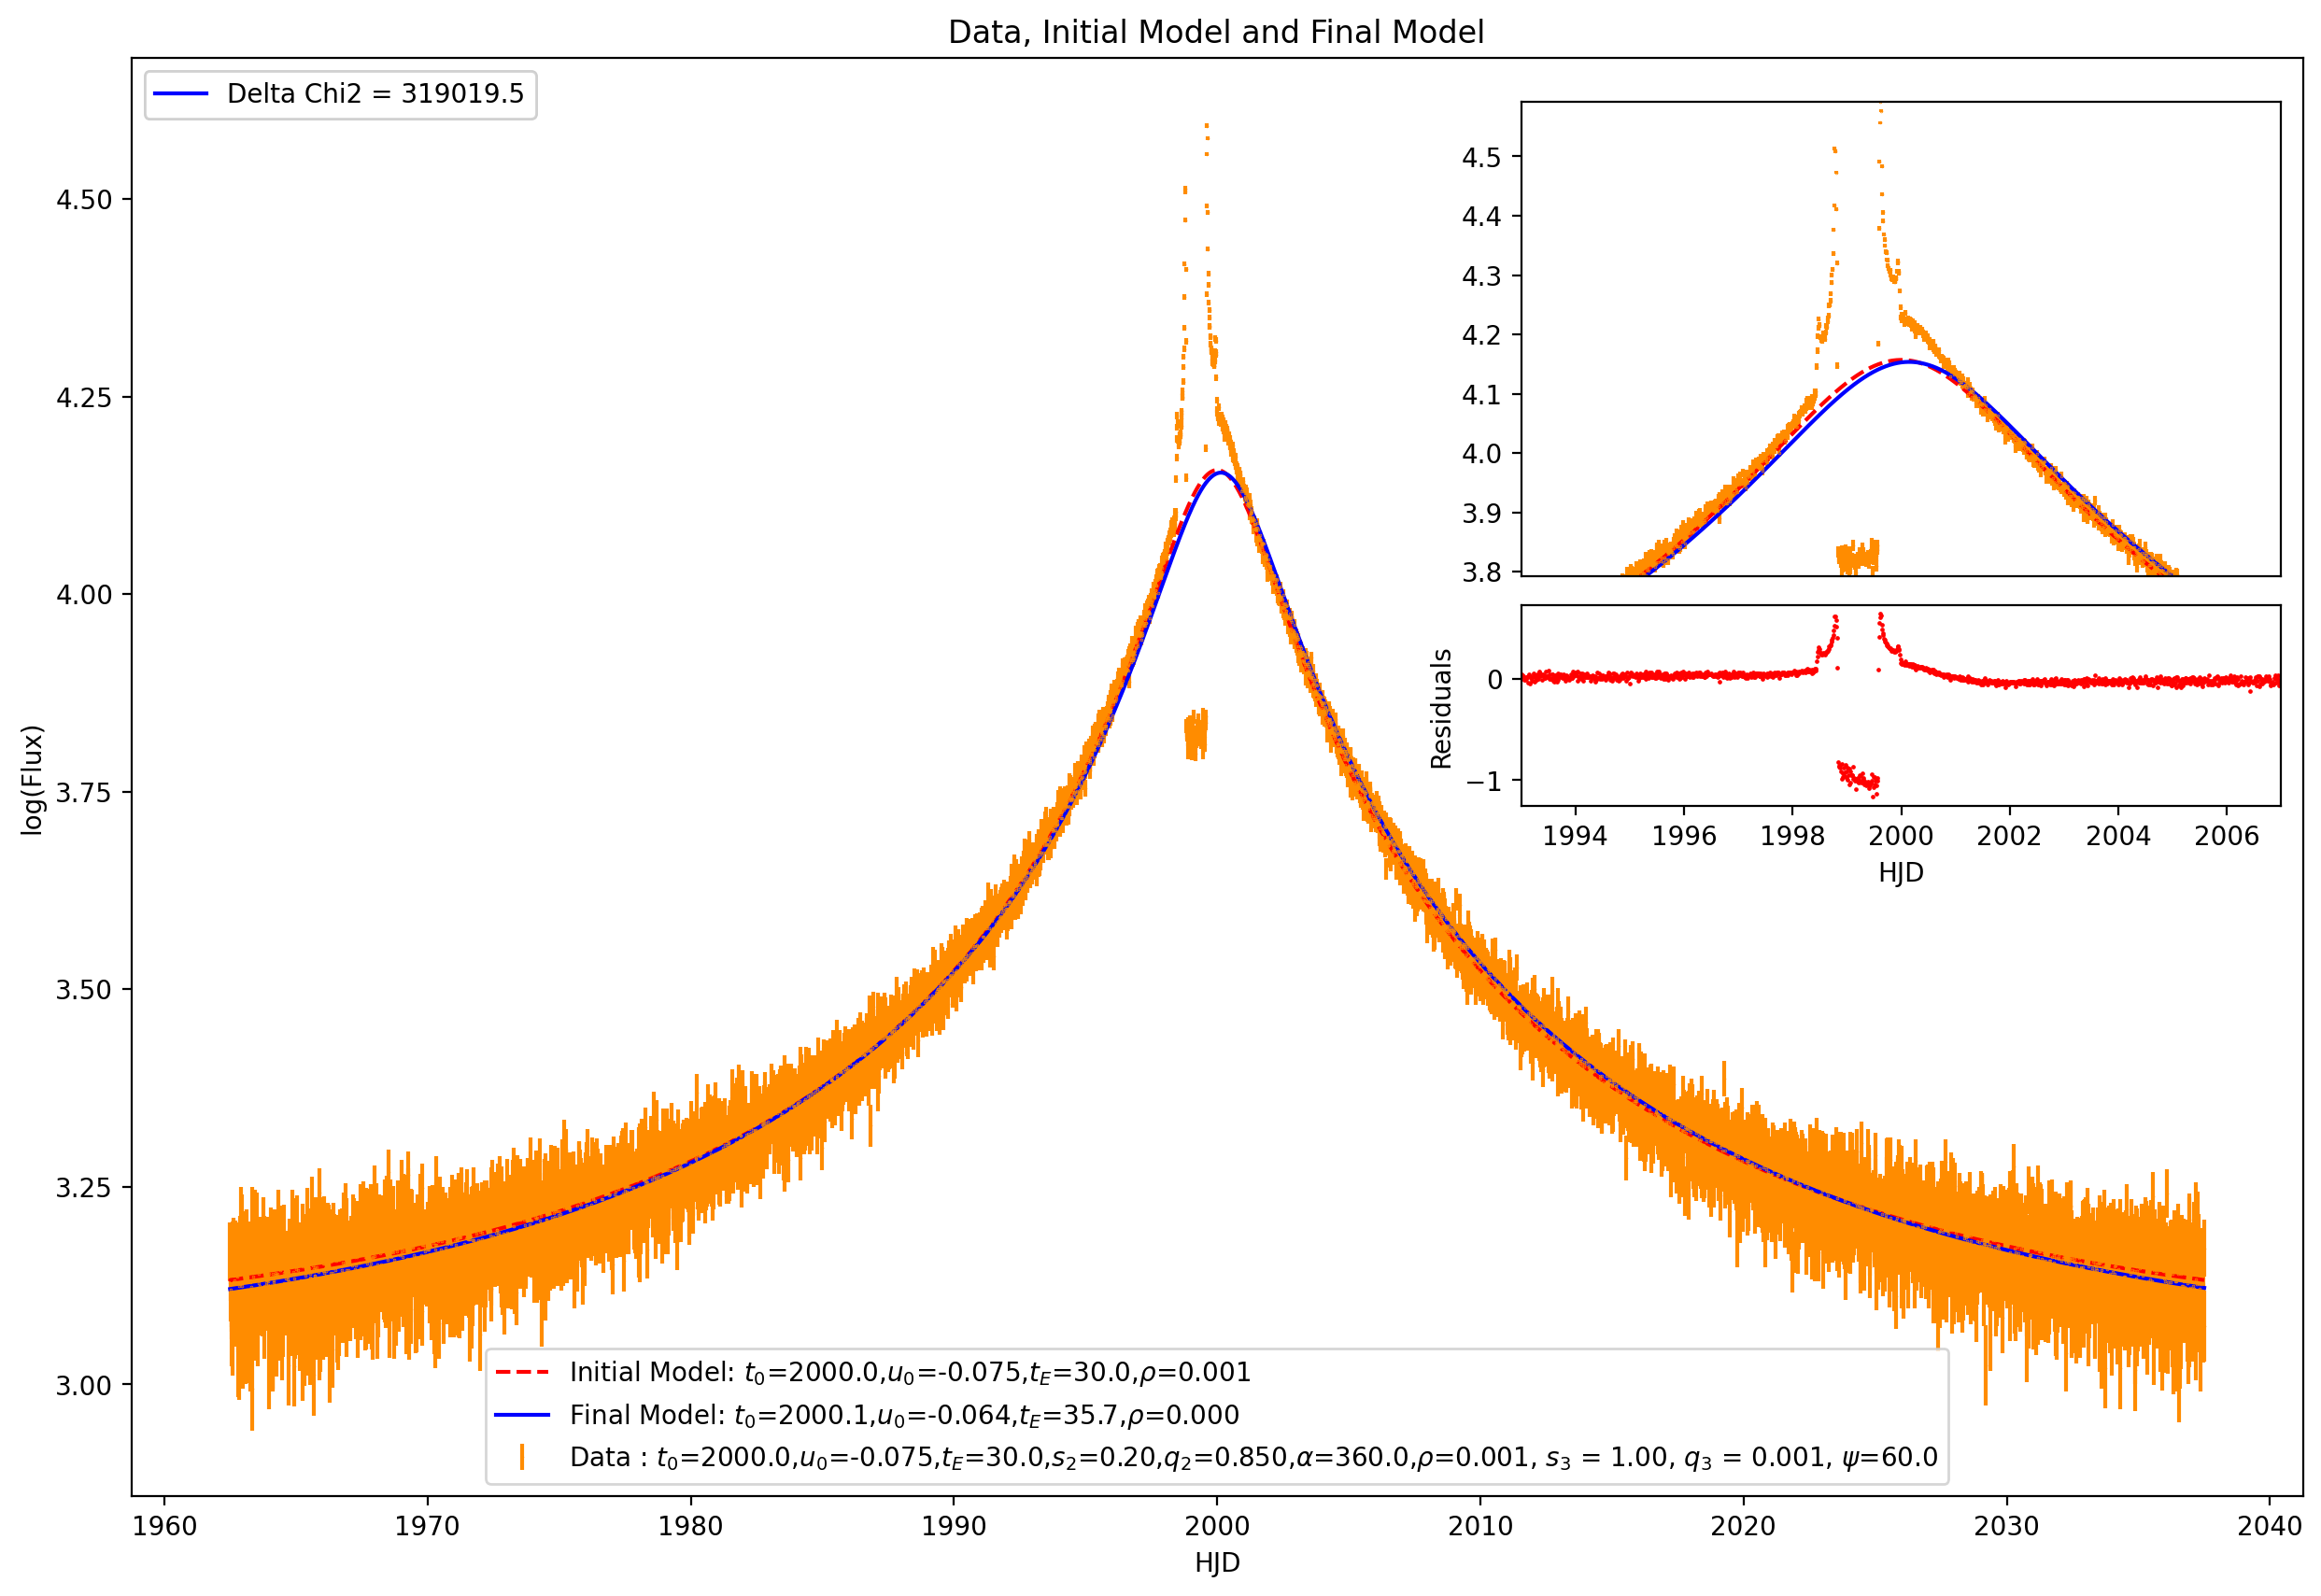

In [32]:
plot_init_final(params_pspl, params_psplfinal, my_data, params_cb, deltax2fin) #

In [2]:
import numpy as np
testlist = np.linspace(0.0,0.0,1,endpoint=False)
print(testlist)

[0.]


Test RT Model

In [1]:
#Format data file

import numpy as np
import os
import MulensModel as mm


def fluxtomag(flux, zeropint = 27.615):
    return -2.5*np.log10(flux) + zeropint


fu0 = -0.27
falpha = 0.0
alpha = 360.0 - falpha
file_name = "../Multiple_lc_run2-Me/s20p2s30p9psi60.0alpha%.1f/u%.3falpha%d"%(falpha,fu0,alpha)

#Read CB data
hjd, cbflux, cbflux_err = np.loadtxt(file_name+"_flux.txt", usecols=[0,1,2], unpack=True)
my_data = mm.MulensData([hjd, cbflux, cbflux_err], phot_fmt="flux", chi2_fmt="flux")
true_params = np.loadtxt(file_name+"_info.txt", skiprows=1)
params_cb = {"t_0": true_params[0], "u_0": true_params[1], "t_E": true_params[2], "s2": true_params[3], "q2": true_params[4], "alpha": true_params[5], "rho": true_params[6], "s3": true_params[7], "q3": true_params[8], "psi": true_params[9]}

"""
#Read binary data
hjd, binaryflux, binaryflux_err = np.loadtxt(file_name+"_binflux.txt", usecols=[0,1,2], unpack=True)
my_data_bin = mm.MulensData([hjd, binaryflux, binaryflux_err], phot_fmt="flux", chi2_fmt="flux")
true_params = np.loadtxt(file_name+"_bininfo.txt", skiprows=1)
params_bin = {"t_0": true_params[0], "u_0": true_params[1], "t_E": true_params[2], "s": true_params[3], "q": true_params[4], "alpha": true_params[5], "rho": true_params[6]}

#Read planet data
hjd, planetflux, planetflux_err = np.loadtxt(file_name+"_planetflux.txt", usecols=[0,1,2], unpack=True)
my_data_planet = mm.MulensData([hjd, planetflux, planetflux_err], phot_fmt="flux", chi2_fmt="flux")
true_params = np.loadtxt(file_name+"_planetinfo.txt", skiprows=1)
params_planet = {"t_0": true_params[0], "u_0": true_params[1], "t_E": true_params[2], "s": true_params[3], "q": true_params[4], "alpha": true_params[5], "rho": true_params[6]}
"""
true_chisq = 0.

"""
#convert flux to magnitudes
binarymag = fluxtomag(binaryflux)
planetmag = fluxtomag(planetflux)
binarymag_err = 2.5*binaryflux_err/binaryflux
planetmag_err = 2.5*planetflux_err/planetflux
"""
cbmag = fluxtomag(cbflux)
cbmag_err = 2.5*cbflux_err/cbflux

#Save data
#np.savetxt("../Multiple_lc_run2-Me/u%.3falpha%d_RTtest_binflux.txt"%(fu0,alpha), np.column_stack((binarymag, binarymag_err, hjd)), fmt = '%.4f', header = 'Mag, err, HJD')
#np.savetxt("../Multiple_lc_run2-Me/u%.3falpha%d_RTtest_planetflux.txt"%(fu0,alpha), np.column_stack((planetmag, planetmag_err, hjd)), fmt = '%.4f', header = 'Mag, err, HJD')
np.savetxt("../Multiple_lc_run2-Me/u%.3falpha%d_RTtest_flux.txt"%(fu0,alpha), np.column_stack((cbmag, cbmag_err, hjd)), fmt = '%.4f', header = 'Mag, err, HJD')





In [21]:
import RTModel as rt

rtm = rt.RTModel('../Multiple_lc_run2-Me/RTtest_event1')
rtm.config_Reader(binning = 4000, renormalize=0, otherseasons=0)
rtm.Reader()

*********************
****   RTModel   ****
*********************
Event name: /Users/murlidhar.4/Documents/Projects/microlens/Multiple_lc_run2-Me/RTtest_event1
Number of processors: 10
- Launching: Reader
  Pre-processing data...
  OK


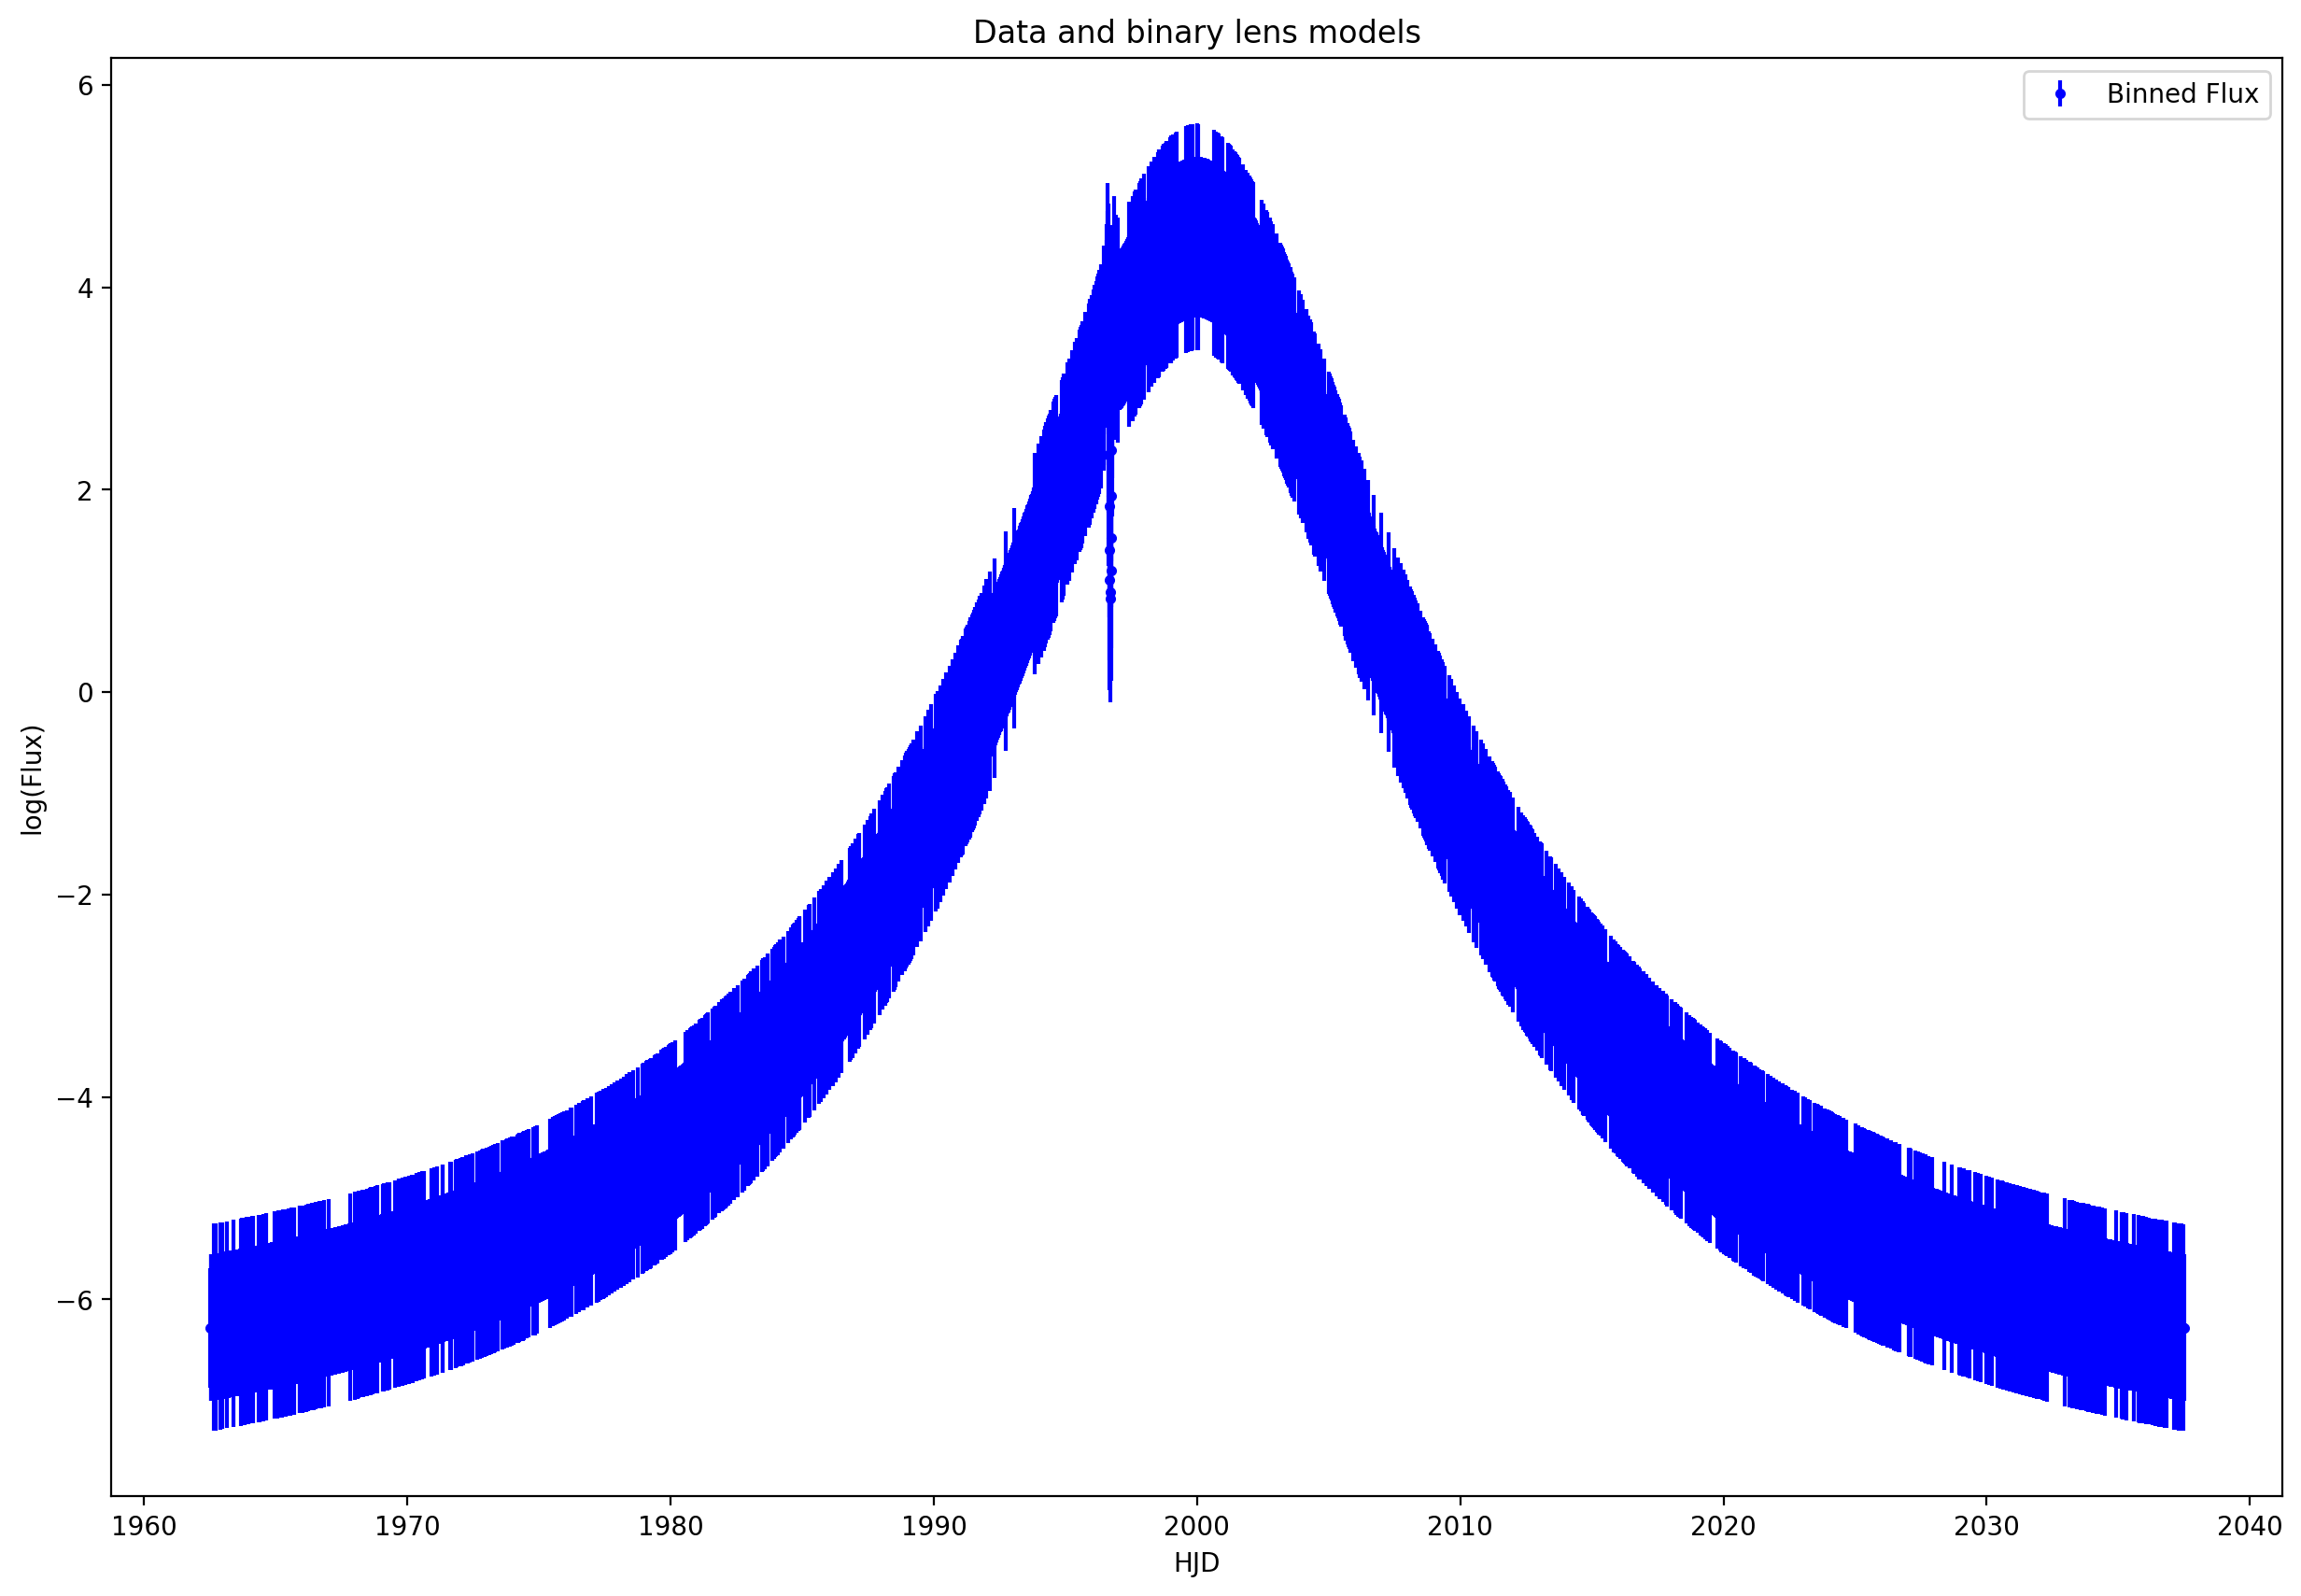

In [44]:
def magtoflux(mag, zeropint = 27.615):
    return 10**((mag - zeropint)/2.5)

#plot data
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (15,10), dpi = 200)
#dat = ax.errorbar(my_data.time, np.log10(cbflux), yerr=cbflux_err/(cbflux*np.log(10)), fmt= '.', color='darkorange', markersize=0.5, label = r'Data : $t_0$=%.1f,$u_0$=%.3f,$t_E$=%.1f,$s_2$=%0.2f,$q_2$=%0.3f,$\alpha$=%0.1f,$\rho$=%0.3f, $s_3$ = %0.2f, $q_3$ = %0.3f, $\psi$=%0.1f'%(params_cb['t_0'], params_cb['u_0'], params_cb['t_E'], params_cb['s2'], params_cb['q2'], params_cb['alpha'], params_cb['rho'], params_cb['s3'], params_cb['q3'], params_cb['psi']))
t, bindmag, err = np.loadtxt("../Multiple_lc_run2-Me/RTtest_event1/LCToFit.txt", usecols=[1,2,3], skiprows=1, unpack=True)
bindmag = bindmag*1e+9
err = err*1e+9
bindflux = magtoflux(bindmag)
fluxerr = err*bindflux*np.log(10)/2.5
ax.errorbar(t, np.log10(bindflux), yerr = fluxerr/(bindflux*np.log(10)), fmt = '.', color = 'blue', label = 'Binned Flux')
ax.set_xlabel('HJD')
ax.set_ylabel('log(Flux)')
ax.set_title('Data and binary lens models')

np.savetxt("../Multiple_lc_run2-Me/s20p2s30p9psi60.0alpha0.0/u-0.270alpha360_fluxrt.txt", np.column_stack((t, bindflux, fluxerr)), header = 'HJD, Flux, err')
#plt.xlim(1995, 2005)
#plt.ylim(8.8, 8.6)
#flip y axis

plt.legend(loc='best')
plt.show()



In [40]:
bindflux

array([5.23033261e-07, 5.24356170e-07, 5.25417246e-07, ...,
       5.25948663e-07, 5.25151757e-07, 5.24356170e-07])

In [5]:
import RTModel as rt

t_0 = params_bin['t_0']
u_0 = params_bin['u_0']
t_E = params_bin['t_E']
rho = params_bin['rho']
sbin = params_bin['s']
qbin = params_bin['q']
alphabin = 360. - params_bin['alpha'] #convert to alpha triplelens

sgns = np.random.choice([-1,1], size = 7)
params_bininit = {'t_0': 2002, 'u_0': -0.05, 't_E': 32., 's': 0.3, 'q': 0.7, 'alpha': 250., 'rho': 0.001            }#{'t_0': t_0 + sgns[0]*0.25, 'u_0': u_0 + sgns[1]*0.025*u_0, 't_E': t_E + sgns[2]*0.025*t_E, 's': sbin + sgns[3]*0.025*sbin, 'q': qbin + sgns[4]*0.025*qbin, 'alpha': alphabin + sgns[5]*0.5, 'rho': rho + sgns[6]*0.025*rho}
params_bininit['alpha'] = np.pi - np.radians(params_bininit['alpha']) #alpha RT Model/vbml in radians
with open("/Users/murlidhar.4/Documents/Projects/microlens/Multiple_lc_run2-Me/RTtest_event1/initcond.txt", "w") as f:
    f.write('%.3f %.4f %.3f %.3f %.4f %.2f %.2f'%(params_bininit['s'], params_bininit['q'], params_bininit['u_0'], params_bininit['alpha'], params_bininit['rho'], params_bininit['t_E'], params_bininit['t_0']))


rtm = rt.RTModel('../Multiple_lc_run2-Me/RTtest_event1')
#rtm.config_Reader(binning = 1000000, renormalize = 0, thresholdoutliers = 1000000)

rtm.Reader()
rtm.InitCond()
rtm.config_LevMar(nfits=5, timelimit=6000.0, maxsteps = 50, bumperpower=2.0)
rtm.launch_fits('LS')
#rtm.LevMar('LS01', parameters_file = '../Multiple_lc_run2-Me/arjunevent/initcond.txt')

*********************
****   RTModel   ****
*********************
Event name: /Users/murlidhar.4/Documents/Projects/microlens/Multiple_lc_run2-Me/RTtest_event1
Number of processors: 10
- Launching: Reader
  Pre-processing data...
  OK
- Launching: InitCond
  Setting initial conditions...
Peaks:  2000.4110  1999.7340  
  OK
- Binary-lens-Single-source fits
Fits completed: 100%|██████████| 226/226 [01:16<00:00,  2.95it/s]


In [6]:
rtm.ModelSelector('LS')


- Selecting models for Binary-lens-Single-source fits
  OK


In [7]:
rtm.cleanup_preliminary_models()
rtm.Finalizer()

- Launching: Finalizer
  Making final assessment for this event
  LS: 5166323.022886
  
  BestPlanetary: N/A
  BestBinary: 5166323.022886
  
  Successful: Binary lens
  ----
  Number of alternative models: 1
  
  chisquare   model
  5166323.022886 LS0007-4.txt
  OK


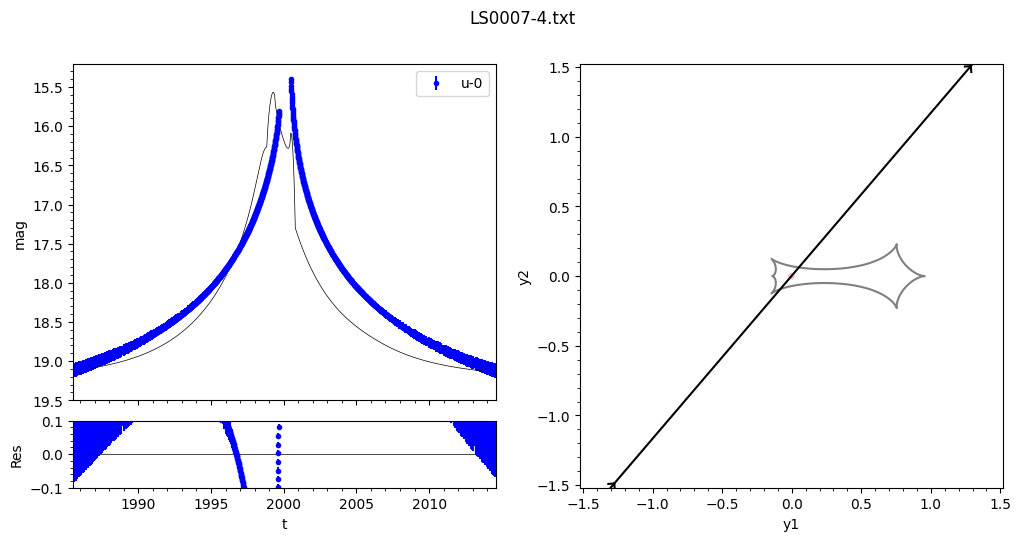

Parameters
s = 1.49501651 +- 0.00067
q = 0.12681952 +- 0.00078
u0 = 0.00162502 +- 0.00019
alpha = 4.0045399 +- 0.0011
rho = 0.01910850 +- 0.00012
tE = 7.269696 +- 0.031
t0 = 2000.0378486 +- 0.0014

blending = [-0.46401261]
baseline = [19.23766912]
chi2 =5166323.022885866


In [9]:
import RTModel.plotmodel as plm
import glob

event = '/Users/murlidhar.4/Documents/Projects/microlens/Multiple_lc_run2-Me/RTtest_event1'
models = glob.glob(event +'/FinalModels/*')
model = models[0]#'/Users/murlidhar.4/Documents/Projects/microlens/Multiple_lc_run2-Me/RTtest_event1/FinalModels/LS0145-3.txt'# let's plot the first of the best models

myplot = plm.plotmodel(eventname = event, modelfile = model)


In [9]:
f = open(model, 'r')

FileNotFoundError: [Errno 2] No such file or directory: '../Multiple_lc_run2-Me/RTtest_event1/FinalModels/LS0145-3.txt'

In [30]:
import numpy as np
u0, tE, rho = np.loadtxt("fit_params.txt", unpack= True, skiprows=1,usecols=(2,3,4))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


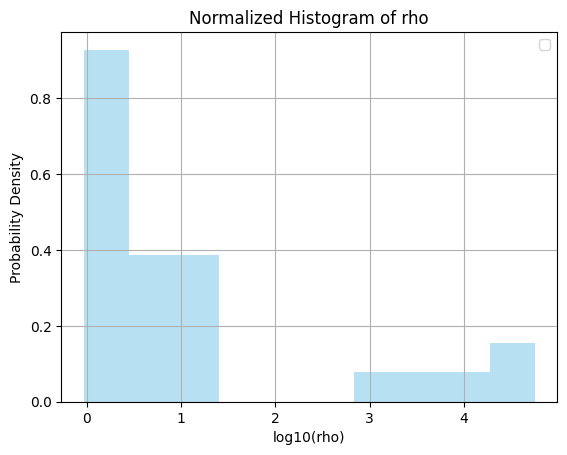

In [37]:
#Plot a histogram for the distribution of u0
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import expon

# Generate random data for demonstration
np.random.seed(42)  # For reproducibility

data = u0
#consider data less than 100 only

# Create a histogram and normalize it
bins = 10
hist, bin_edges = np.histogram(data, bins=bins, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2



# Plot the histogram
plt.hist(data, bins=bins, density=True, alpha=0.6, color='skyblue')



plt.xlabel('log10(rho)')
plt.ylabel('Probability Density')
plt.title('Normalized Histogram of rho')
plt.xlim(0,100)
plt.legend()
plt.grid(True)
plt.show()
